In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications import MobileNetV2

/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = tf.keras.utils.image_dataset_from_directory(
    './data/raw/Garbage classification/Garbage classification',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2527 files belonging to 6 classes.


In [3]:
ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
CLASS_NAMES = ds.class_names

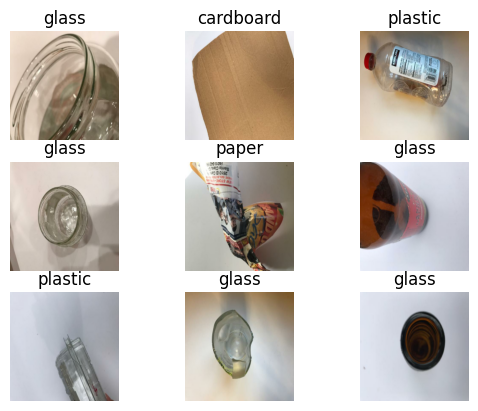

In [5]:
import matplotlib.pyplot as plt

for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [6]:
DATASET_SIZE = 2527 / 32

In [7]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

In [8]:
train_dataset = ds.take(train_size)
rem = ds.skip(train_size)
test_dataset = rem.take(test_size)
val_dataset = rem.skip(test_size)


In [9]:
len(list(test_dataset))

11

In [10]:
NUM_CLASSES = len(CLASS_NAMES)

In [11]:
BATCH_SIZE = 32

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [13]:
base_model_mbnv2 = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
    classes=NUM_CLASSES
)

base_model_mbnv2.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = inputs

x = base_model_mbnv2(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model_mbnv2 = keras.Model(inputs, outputs)

model_mbnv2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02

In [14]:

import sys
sys.path.insert(0, "../")
from mlflow_emissions_sdk.experiment_tracking_training import EmissionsTrackerMlflow

In [15]:
model_mbnv2.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 1

tracker_info = {
    "tracking_uri": "http://127.0.0.1:5000",
    "experiment_name": "keras_present_3",
    "run_name": "mobile_net_v2",
    "flavor": "keras"
}

runner = EmissionsTrackerMlflow()
runner.read_params(tracker_info)

runner.start_training_job()

hist = model_mbnv2.fit(train_dataset, epochs=epochs, validation_data=val_dataset, batch_size=32)

runner.end_training_job()
runner.accuracy_per_emission(model_mbnv2, test_dataset)




[codecarbon INFO @ 13:17:15] [setup] RAM Tracking...
[codecarbon INFO @ 13:17:15] [setup] GPU Tracking...
[codecarbon INFO @ 13:17:15] No GPU found.
[codecarbon INFO @ 13:17:15] [setup] CPU Tracking...
[codecarbon WARNING @ 13:17:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:17:15] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 13:17:15] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 13:17:15] >>> Tracker's metadata:
[codecarbon INFO @ 13:17:15]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 13:17:15]   Python version: 3.11.6
[codecarbon INFO @ 13:17:15]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 13:17:15]   Available RAM : 16.000 GB
[codecarbon INFO @ 13:17:15]   CPU count: 10
[codecarbon INFO @ 13:17:15]   CPU model: Apple M2 Pro
[codecarbon INFO @ 13:17:15]   GPU count: None
[codecarbon INFO @ 13:17:15]   GPU model: None
2023/10/27 13:17:18 IN

55/55 [==============================] - ETA: 0s - loss: 1.5305 - accuracy: 0.4062

[codecarbon INFO @ 13:17:33] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:17:33] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:17:33] 0.000202 kWh of electricity used since the beginning.


1/1 [==============================] - 0s 463ms/step
INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpewvv90hu/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpewvv90hu/model/data/model/assets
[codecarbon INFO @ 13:17:48] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:17:48] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:17:48] 0.000404 kWh of electricity used since the beginning.
2023/10/27 13:17:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
[codecarbon INFO @ 13:17:59] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:17:59] Energy consumed for all CPUs : 0.000479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:17:59] 0.000547 kWh of electricity used since the beginning.


11/11 [==============================] - 3s 196ms/step - loss: 1.1785 - accuracy: 0.5767


In [16]:
x_test = []
for image, label in test_dataset.take(1):
    for i in range(10):
        x_test.append(np.array([image[i]]))

runner.emissions_per_10_inferences(model_mbnv2, x_test)

[codecarbon WARNING @ 13:18:02] Already started tracking


1/1 [==============================] - 0s 31ms/step


[codecarbon WARNING @ 13:18:03] Tracker already stopped !
[codecarbon INFO @ 13:18:03] Energy consumed for RAM : 0.000074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:18:03] Energy consumed for all CPUs : 0.000525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:18:03] 0.000599 kWh of electricity used since the beginning.


In [17]:
base_model_nasnetmobile = keras.applications.NASNetMobile(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
    classes=NUM_CLASSES
)

base_model_nasnetmobile.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = inputs

x = base_model_nasnetmobile(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model_nasnetmobile = keras.Model(inputs, outputs)

model_nasnetmobile.summary()

19993432/19993432 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 8, 8, 1056)        4269716   
                                                                 
 global_average_pooling2d_1  (None, 1056)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1056)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 6342      
                                                                 
Total params: 4276058 (16.31 MB)
Trainable params: 6342 (24.

In [18]:
model_nasnetmobile.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 1

tracker_info = {
    "tracking_uri": "http://127.0.0.1:5000",
    "experiment_name": "keras_present_3",
    "run_name": "nasnetmobile",
    "flavor": "keras"
}

runner = EmissionsTrackerMlflow()
runner.read_params(tracker_info)

runner.start_training_job()

hist = model_nasnetmobile.fit(train_dataset, epochs=epochs, validation_data=val_dataset, batch_size=32)

runner.end_training_job()
runner.accuracy_per_emission(model_nasnetmobile, test_dataset)
runner.emissions_per_10_inferences(model_nasnetmobile, x_test)

[codecarbon INFO @ 13:18:08] [setup] RAM Tracking...
[codecarbon INFO @ 13:18:08] [setup] GPU Tracking...
[codecarbon INFO @ 13:18:08] No GPU found.
[codecarbon INFO @ 13:18:08] [setup] CPU Tracking...
[codecarbon WARNING @ 13:18:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:18:09] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 13:18:09] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 13:18:09] >>> Tracker's metadata:
[codecarbon INFO @ 13:18:09]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 13:18:09]   Python version: 3.11.6
[codecarbon INFO @ 13:18:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 13:18:09]   Available RAM : 16.000 GB
[codecarbon INFO @ 13:18:09]   CPU count: 10
[codecarbon INFO @ 13:18:09]   CPU model: Apple M2 Pro
[codecarbon INFO @ 13:18:09]   GPU count: None
[codecarbon INFO @ 13:18:09]   GPU model: None
2023/10/27 13:18:11 WA

11/55 [=====>........................] - ETA: 16s - loss: 7.0873 - accuracy: 0.1648

[codecarbon INFO @ 13:18:26] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:18:26] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:18:26] 0.000202 kWh of electricity used since the beginning.


52/55 [===========================>..] - ETA: 1s - loss: 5.1254 - accuracy: 0.1707

[codecarbon INFO @ 13:18:41] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:18:41] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:18:41] 0.000404 kWh of electricity used since the beginning.


1/1 [==============================] - 3s 3s/step


[codecarbon INFO @ 13:18:56] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:18:56] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:18:56] 0.000606 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:19:11] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:19:11] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:19:11] 0.000809 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:19:27] Energy consumed for RAM : 0.000127 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:19:27] Energy consumed for all CPUs : 0.000897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:19:27] 0.001024 kWh of electricity used since the beginning.


INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpb8rqrpun/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpb8rqrpun/model/data/model/assets
[codecarbon INFO @ 13:19:42] Energy consumed for RAM : 0.000151 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:19:42] Energy consumed for all CPUs : 0.001074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:19:42] 0.001225 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:19:57] Energy consumed for RAM : 0.000176 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:19:57] Energy consumed for all CPUs : 0.001249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:19:57] 0.001425 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:20:12] Energy consumed for RAM : 0.000201 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:20:12] Energy consumed for all CPUs : 0.001426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:20:12] 0.001628 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:20:22] Energy consumed for RAM : 0.000219 kWh. RAM 

11/11 [==============================] - 4s 343ms/step - loss: 1.8897 - accuracy: 0.2699
